# CNN: Regression experiments

script: jupyter-gpu.sbatch  
partition: gpu  
conda env: torch-ni-ny  
data: /scratch/groups/jyeatman/samjohns-projects/data 
  
notable changes:
- add train-test split
- (network) add extra final fully connected layer
- (network) change fc nonlinearity from relu to elu

## Step 1: Prepare Data

In [22]:
import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

# these are required for defining the regession ImageFolder
from typing import Dict, Any
from torchvision import datasets

import pandas as pd
import numpy as np

In [11]:
import os, sys, pickle

import struct
from array import array
from os import path

import png
from PIL import Image
from PIL import ImageOps

In [12]:
proj_dir = '/scratch/groups/jyeatman/samjohns-projects'
image_subdir = '/data/fsa-data/images/images-thickness-sphere-processed'
image_dir = proj_dir + image_subdir
os.chdir(proj_dir)

In [13]:
# dataset specific directories
data_dir = '/scratch/groups/jyeatman/samjohns-projects/data'
pheno_dir = '/scratch/groups/jyeatman/samjohns-projects/data/hbn-reading-age-data'
label_dir = data_dir + '/labels'
os.listdir(pheno_dir)

['agef.pkl',
 'wiat_reading.csv',
 'nonblank_inds.pkl',
 'hbn_ages_blanks.csv',
 'readf.pkl']

In [14]:
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms

class CustomImageDataset(Dataset):
    """ Custom dataset, like ImageFolder, works with arbitrary image labels.
        Labels should be a .csv in the format:
            image1filename.png, image1label
            image2filename.png, image2label
            ...
        Useful for regression; circumvents ImageFolder classification scheme
        which requires that images be sorted into subfolders corresponding to class names.
    """
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## This section formats the dataset
- It is unnecessary to execute unless preparing a new dataset
- (In which case, new image directories, pheno files, and label output files should be set)

In [15]:
# first read in filenames and create a filename dataframe

image_filenames = os.listdir(image_dir)

In [16]:
# strip EID from image filenames; first 16 characters of filename string
EID_length = 16
sub_filenames = [name[:EID_length] for name in image_filenames]
assert len(sub_filenames) == len(image_filenames)

In [66]:
d = {'EID': sub_filenames, 'Filename': image_filenames}

In [67]:
filename_df = pd.DataFrame(d)

In [68]:
filename_df.head()

,EID,Filename
0,sub-NDARKB614KGY,sub-NDARKB614KGY.fsa.lh.thickness--69.91--2.30...
1,sub-NDARGP399TDM,sub-NDARGP399TDM.fsa.lh.thickness--64.15--0.05...
2,sub-NDARJT615WM7,sub-NDARJT615WM7.fsa.lh.thickness--69.85--1.94...
3,sub-NDARCZ947WU5,sub-NDARCZ947WU5.fsa.lh.thickness--66.48-4.59-...
4,sub-NDARPL215MTH,sub-NDARPL215MTH.fsa.lh.thickness--61.84--3.62...


In [72]:
age_df = pd.read_csv(pheno_dir+'/hbn_ages_blanks.csv', header=None)

In [73]:
age_df.columns = ['EID', 'Age']
age_df.head()

,EID,Age
0,sub-NDARAA075AMK,7
1,sub-NDARAA536PTU,12
2,sub-NDARAA948VFH,8
3,sub-NDARAB055BPR,11
4,sub-NDARAB348EWR,6


In [74]:
age_df_noblanks = age_df[age_df.Age != ' ']

In [75]:
pheno_df = pd.merge(filename_df, age_df_noblanks, on='EID', how='left')

In [76]:
# filter out nan's (for which EID didn't appear in Age data)
pheno_df = pheno_df.dropna()

In [79]:
# save df as .csv
label_dir = data_dir + '/labels'
if not os.path.exists(label_dir):
    os.makedirs(label_dir)
pheno_df_nosub = pheno_df[['Filename', 'Age']]
pheno_df_nosub

,Filename,Age
0,sub-NDARKB614KGY.fsa.lh.thickness--69.91--2.30...,11
3,sub-NDARCZ947WU5.fsa.lh.thickness--66.48-4.59-...,9
4,sub-NDARPL215MTH.fsa.lh.thickness--61.84--3.62...,10
5,sub-NDARRW100AU0.fsa.lh.thickness--67.39--2.71...,8
7,sub-NDARKF615JNZ.fsa.lh.thickness--61.16-0.99-...,10
...,...,...
23889,sub-NDARCB627KDN.fsa.lh.thickness--66.79-2.73-...,11
23890,sub-NDARBW525JHY.fsa.lh.thickness--62.15--4.96...,5
23893,sub-NDARUX315PE6.fsa.lh.thickness--66.98-1.74-...,14
23894,sub-NDARKL327YDQ.fsa.lh.thickness--65.66-2.39-...,16


In [80]:
pheno_df_nosub.to_csv(label_dir+'/age_thickness_sphere_labels.csv', index=False)

In [81]:
os.listdir(label_dir)

['age_labels.csv', 'age_thickness_sphere_labels.csv']

## Load dataset
- Continue from this point if images and label files are already created

In [17]:
test_df = pd.read_csv(f'{label_dir}/age_thickness_sphere_labels.csv')

In [18]:
test_df

,Filename,Age
0,sub-NDARKB614KGY.fsa.lh.thickness--69.91--2.30...,11
1,sub-NDARCZ947WU5.fsa.lh.thickness--66.48-4.59-...,9
2,sub-NDARPL215MTH.fsa.lh.thickness--61.84--3.62...,10
3,sub-NDARRW100AU0.fsa.lh.thickness--67.39--2.71...,8
4,sub-NDARKF615JNZ.fsa.lh.thickness--61.16-0.99-...,10
...,...,...
15638,sub-NDARCB627KDN.fsa.lh.thickness--66.79-2.73-...,11
15639,sub-NDARBW525JHY.fsa.lh.thickness--62.15--4.96...,5
15640,sub-NDARUX315PE6.fsa.lh.thickness--66.98-1.74-...,14
15641,sub-NDARKL327YDQ.fsa.lh.thickness--65.66-2.39-...,16


In [19]:
class ToFloat(object):
    """Converts the datatype in sample to torch.float32 datatype."""

    def __call__(self, target):
        target_tensor = torch.tensor(target)
        return target_tensor.to(torch.float32)

In [20]:
# load total dataset
thickness = CustomImageDataset(f'{label_dir}/age_thickness_sphere_labels.csv', image_dir, transform=transforms.ConvertImageDtype(torch.float32), target_transform=ToFloat())

In [32]:
# create random split into train and test sets
nsamples = len(thickness)
indices = list(range(nsamples))
ntest = nsamples // 10
ntrain = nsamples - ntest
test_indices = list(np.random.choice(indices, size=ntest, replace=False))
train_indices = list(set(indices) - set(test_indices))
(len(test_indices), len(train_indices))

(1564, 14079)

In [35]:
thickness_train = torch.utils.data.Subset(thickness, train_indices) 
thickness_test = torch.utils.data.Subset(thickness, test_indices) 

In [ ]:
# create dataloaders for convenient batching
# for MNIST
batch_size = 64

trainloader = DataLoader(thickness_train, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
testloader = DataLoader(thickness_test, batch_size=batch_size, shuffle=False, num_workers=3, pin_memory=True)

In [37]:
train_batch = next(iter(trainloader))

In [38]:
train_batch[1].dtype

torch.float32

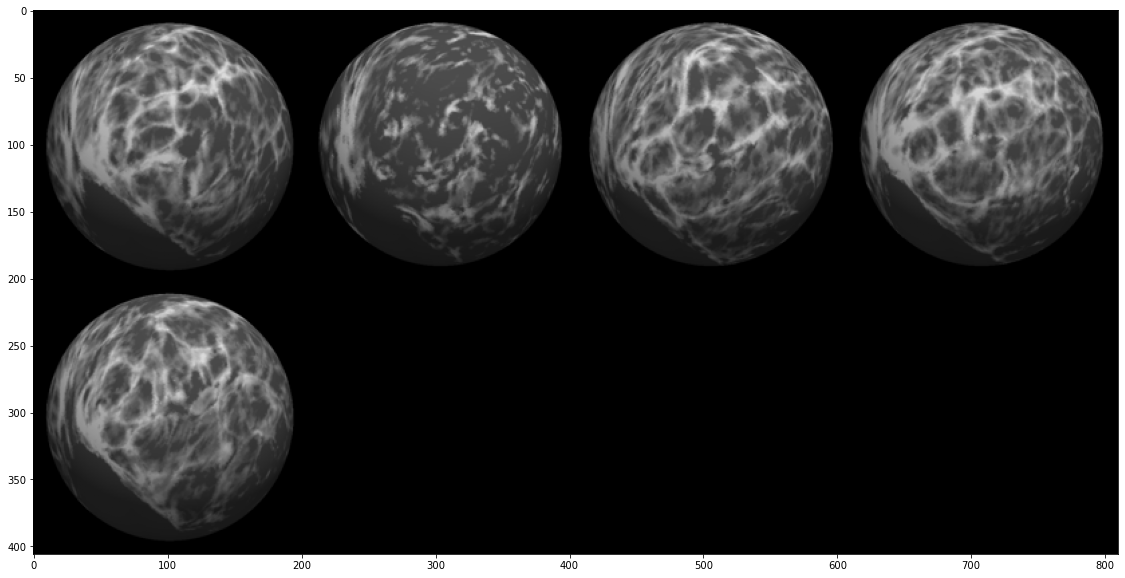

In [39]:
# visualize images

import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # normalization may be required in some cases, but not here
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize = (20,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch (nrows images per row)
out = torchvision.utils.make_grid(inputs[:5], nrow=4)

imshow(out)

In [40]:
train_batch = next(iter(trainloader))

In [41]:
train_batch[0].dtype, train_batch[0].shape

(torch.float32, torch.Size([64, 1, 200, 200]))

## Model training (for testing Freeview image CNN)

In [58]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [59]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Conv2d(1, 4, 4, padding='same')
        self.l2 = nn.Conv2d(4, 16, 4, padding='same')
        self.m1 = nn.MaxPool2d(4, stride=3)
        self.l3 = nn.Conv2d(16, 32, 4, padding='same')
        self.l4 = nn.Conv2d(32, 32, 4, padding='same')
        self.m2 = nn.MaxPool2d(4, stride=2)
        self.l5 = nn.Conv2d(32, 64, 4, padding='same')
        self.l6 = nn.Conv2d(64, 32, 4, padding='same')
        self.m3 = nn.MaxPool2d(4, stride=2)
        self.l7 = nn.Conv2d(32, 32, 4, padding='same')
        self.l8 = nn.Conv2d(32, 32, 4, padding='same')
        self.m4 = nn.MaxPool2d(4, stride=2)
        self.fc1 = nn.Linear(1152, 100)
        self.fc2 = nn.Linear(100, 24)
        self.fc3 = nn.Linear(24, 1)
        
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x)) 
        x = self.m1(x) 
        x = F.relu(self.l3(x)) 
        x = F.relu(self.l4(x)) 
        x = self.m2(x) 
        x = F.relu(self.l5(x)) 
        x = F.relu(self.l6(x)) 
        x = self.m3(x) 
        x = F.relu(self.l7(x)) 
        x = F.relu(self.l8(x)) 
        x = self.m4(x) 
        x = torch.flatten(x, 1) # do not flatten batch dimensions
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        return x

In [60]:
from torchsummary import summary

In [61]:
cnn = ConvNet().to(device)

In [62]:
summary(cnn, (1, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]              68
            Conv2d-2         [-1, 16, 200, 200]           1,040
         MaxPool2d-3           [-1, 16, 66, 66]               0
            Conv2d-4           [-1, 32, 66, 66]           8,224
            Conv2d-5           [-1, 32, 66, 66]          16,416
         MaxPool2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          32,832
            Conv2d-8           [-1, 32, 32, 32]          32,800
         MaxPool2d-9           [-1, 32, 15, 15]               0
           Conv2d-10           [-1, 32, 15, 15]          16,416
           Conv2d-11           [-1, 32, 15, 15]          16,416
        MaxPool2d-12             [-1, 32, 6, 6]               0
           Linear-13                  [-1, 100]         115,300
           Linear-14                   

In [64]:
# alternate training / testing loop from previous;
# somewhat simplified; this version does not use an 'early stopping'
# paradigm that caches best test-set parameters.

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X_cpu, y_cpu) in enumerate(dataloader):
        # Compute prediction and loss
        X = X_cpu.to(device) # must put model and data both on gpu (if available)
        y = y_cpu.to(device)
        pred = model(X)
        pred = torch.squeeze(pred)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X_cpu, y_cpu in dataloader:
            X = X_cpu.to(device) # must put model and data both on gpu (if available)
            y = y_cpu.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

Age: 6.0


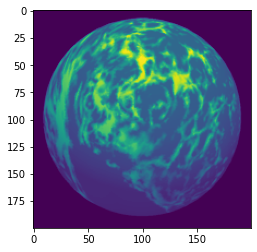

In [65]:
ind = 5
print(f'Age: {y[ind]}')
plt.imshow(np.squeeze(X.numpy()[ind]))

## Training cell below
- caution: can take a long time to execute
- loading data (in epoch one) can take a long time;
- subsequent epochs go faster

In [67]:
len([1])

1

In [69]:
lrs = [1e-2, 1e-3, 1e-4, 1e-5]
batch_sizes = [4, 8, 16, 32, 64, 128]
weight_decays = [0] #[0, 1e-1, 1e-2]

In [63]:
model = cnn
loss_fn = nn.MSELoss() # note that we use MSE, somewhat atypical for cnn
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)

In [70]:
def train(model, loss_fn, optimizer, trainl, testl, epochs=None):
    """ Trains model by minimizing loss_fn using optimizer.
        Trains on trainl data and tests occassionally on testl data.
        Loops over training dataset for # determined by epochs.
        No returns; the model is trained in-place.
    """
    # training happens here; can take a long time
    if epochs is None:
        epochs = 50
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(trainloader, model, loss_fn, optimizer)
        test_loop(testloader, model, loss_fn)
    print("Done!")

In [71]:
# loop over several training models -- grid search
epochs = 50
for lr in lrs:
    for batch_size in batch_sizes:
        for wd in weight_decays:
            print(f'lr: {lr}, batch size: {batch_size}')
            # create dataloaders for convenient batching
            trainloader = DataLoader(thickness_train, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
            testloader = DataLoader(thickness_test, batch_size=batch_size, shuffle=False, num_workers=3, pin_memory=True)
            
            model = ConvNet().to(device)
            loss_fn = nn.MSELoss() # note that we use MSE, somewhat atypical for cnn
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
            
            # train here
            train(model, loss_fn, optimizer, trainloader, testloader, epochs=epochs)

lr: 0.01, batch size: 4
Epoch 1
-------------------------------
loss: 144.153473  [    0/14079]
loss: 11.269311  [  400/14079]
loss: 8.331539  [  800/14079]
loss: 3.171064  [ 1200/14079]
loss: 17.281321  [ 1600/14079]
loss: 41.439289  [ 2000/14079]
loss: 10.459274  [ 2400/14079]
loss: 29.705050  [ 2800/14079]
loss: 19.044399  [ 3200/14079]
loss: 13.299497  [ 3600/14079]
loss: 1.942340  [ 4000/14079]
loss: 14.926285  [ 4400/14079]
loss: 14.067893  [ 4800/14079]
loss: 6.456113  [ 5200/14079]
loss: 7.917900  [ 5600/14079]
loss: 9.087406  [ 6000/14079]
loss: 4.418040  [ 6400/14079]
loss: 12.633514  [ 6800/14079]
loss: 9.627067  [ 7200/14079]
loss: 5.175173  [ 7600/14079]
loss: 6.431433  [ 8000/14079]
loss: 24.951693  [ 8400/14079]
loss: 25.446007  [ 8800/14079]
loss: 3.948969  [ 9200/14079]
loss: 2.615141  [ 9600/14079]
loss: 0.578696  [10000/14079]
loss: 3.152335  [10400/14079]
loss: 13.881435  [10800/14079]
loss: 6.668259  [11200/14079]
loss: 9.904140  [11600/14079]
loss: 10.853552  [120

/home/groups/jyeatman/software/anaconda3/envs/torch-ni-ny/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 13.470352 

Epoch 2
-------------------------------
loss: 11.028087  [    0/14079]
loss: 13.023382  [  400/14079]
loss: 10.958691  [  800/14079]
loss: 15.516121  [ 1200/14079]
loss: 13.904965  [ 1600/14079]
loss: 31.850721  [ 2000/14079]
loss: 13.277417  [ 2400/14079]
loss: 8.235691  [ 2800/14079]
loss: 24.980057  [ 3200/14079]
loss: 12.597166  [ 3600/14079]
loss: 7.847003  [ 4000/14079]
loss: 74.855576  [ 4400/14079]
loss: 4.928637  [ 4800/14079]
loss: 5.985416  [ 5200/14079]
loss: 12.593260  [ 5600/14079]
loss: 9.448997  [ 6000/14079]
loss: 10.180795  [ 6400/14079]
loss: 6.739524  [ 6800/14079]
loss: 11.514580  [ 7200/14079]
loss: 3.573725  [ 7600/14079]
loss: 16.699230  [ 8000/14079]
loss: 9.308341  [ 8400/14079]
loss: 5.719752  [ 8800/14079]
loss: 29.557682  [ 9200/14079]


KeyboardInterrupt: 

In [66]:
# training happens here; can take a long time
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(trainloader, model, loss_fn, optimizer)
    test_loop(testloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 123.187477  [    0/14079]
loss: 12.666973  [ 6400/14079]
loss: 12.575032  [12800/14079]


/home/groups/jyeatman/software/anaconda3/envs/torch-ni-ny/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 13.098068 

Epoch 2
-------------------------------


/home/groups/jyeatman/software/anaconda3/envs/torch-ni-ny/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 11.227741  [    0/14079]
loss: 12.669584  [ 6400/14079]
loss: 16.268158  [12800/14079]
Test Error: 
 Avg loss: 12.978889 

Epoch 3
-------------------------------
loss: 14.089298  [    0/14079]
loss: 13.586507  [ 6400/14079]
loss: 12.893544  [12800/14079]
Test Error: 
 Avg loss: 13.363065 

Epoch 4
-------------------------------
loss: 12.748438  [    0/14079]
loss: 13.084368  [ 6400/14079]
loss: 11.416398  [12800/14079]
Test Error: 
 Avg loss: 13.941540 

Epoch 5
-------------------------------
loss: 14.089742  [    0/14079]
loss: 9.209916  [ 6400/14079]
loss: 14.284304  [12800/14079]
Test Error: 
 Avg loss: 16.187025 

Epoch 6
-------------------------------
loss: 10.773158  [    0/14079]
loss: 9.697067  [ 6400/14079]
loss: 8.532373  [12800/14079]
Test Error: 
 Avg loss: 16.819063 

Epoch 7
-------------------------------
loss: 11.056831  [    0/14079]
loss: 11.327074  [ 6400/14079]
loss: 9.299231  [12800/14079]
Test Error: 
 Avg loss: 16.590822 

Epoch 8
----------------------

In [47]:
# comparison to predicting average
test_df.head()

,Filename,Age
0,sub-NDARKB614KGY.fsa.lh.thickness--69.91--2.30...,11
1,sub-NDARCZ947WU5.fsa.lh.thickness--66.48-4.59-...,9
2,sub-NDARPL215MTH.fsa.lh.thickness--61.84--3.62...,10
3,sub-NDARRW100AU0.fsa.lh.thickness--67.39--2.71...,8
4,sub-NDARKF615JNZ.fsa.lh.thickness--61.16-0.99-...,10


In [33]:
m = test_df.Age.mean()
s = test_df.Age.std()
print(f'Age: (mean, std) = ({m}, {s})')

Age: (mean, std) = (10.811992584542606, 3.661851898546048)


In [85]:
# TO DO: TRAIN!!
# -- NB: will probably have to convert int inputs to float;
# -- since you want float outputs...

### Vestigal
data ingestion appropriate for classificaiton (not regression)

In [5]:
# data ingestion
# done twice: once with .Grayscale() (for new net) and once without (for pretrained net)
# 1. gray (one channel)
data = torchvision.datasets.ImageFolder(root=img_dir,
                                        transform=transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])
                                       )
# 2. rgb (three channel)
data_rgb = torchvision.datasets.ImageFolder(root=img_dir,
                                        transform=transforms.ToTensor())

In [6]:
nsamples = data.__len__()
ntest = nsamples // 10
ntrain = nsamples - ntest

In [7]:
(ntrain, ntest)

(1494, 165)

In [8]:
# split data into test and training datasets
train, test = torch.utils.data.random_split(data, [ntrain, ntest])
train_rgb, test_rgb = torch.utils.data.random_split(data_rgb, [ntrain, ntest])

In [9]:
# dataLoaders
batch_size = 8

trainloader = DataLoader(train, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test, batch_size=batch_size, shuffle=False)

trainl_rgb = DataLoader(train_rgb, batch_size=batch_size, shuffle=True)
testl_rgb = DataLoader(test_rgb, batch_size=batch_size, shuffle=False)

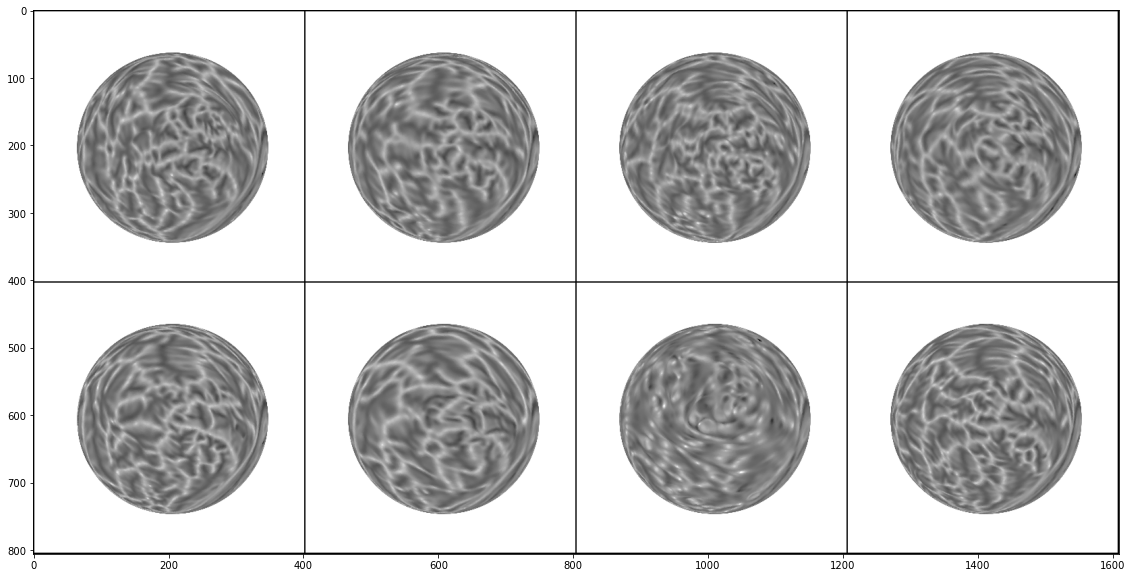

In [10]:
# visualize images

import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # normalization may be required in some cases, but not here
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize = (20,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch (nrows images per row)
out = torchvision.utils.make_grid(inputs, nrow=4)

imshow(out)

In [11]:
d0 = inputs.data[0]

In [12]:
dn = d0.numpy()

In [13]:
# confirming one channel (grayscale): (C, H, W)
dn.shape

(1, 400, 400)

In [14]:
d1 = next(iter(trainl_rgb))

In [15]:
# confirming three channels (rgb): (N, C, H, W)
d1[0].shape

torch.Size([8, 3, 400, 400])

# Define the convolutional network

1. transfer learning
2. cnn from scratch

## v1. transfer learning version

from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [16]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

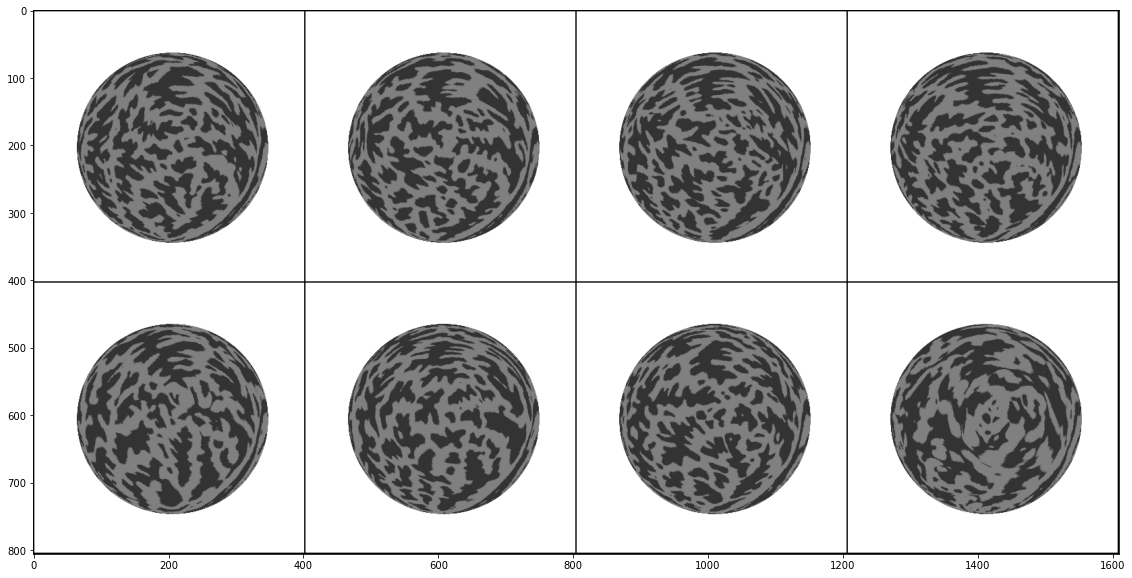

In [36]:
# visualize images

import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # normalization may be required in some cases, but not here
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize = (20,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(trainl_rgb))

# Make a grid from batch (nrows images per row)
out = torchvision.utils.make_grid(inputs, nrow=4)

imshow(out)

In [37]:
# set appropriate (three-channel (rgb)) dataloaders for transfer cnn
dataloaders = {'train': trainl_rgb, 'val': testl_rgb}
dataset_sizes = {'train': ntrain, 'val': ntest}

In [38]:
# easiest
len(dataloaders['val'].dataset.indices)

199

In [39]:
dataset_sizes = {}
for phase, dl in dataloaders.items():
    dataset_sizes[phase] = len(dl.dataset.indices)

In [40]:
dataset_sizes = {phase: len(dl.dataset.indices) for phase, dl in dataloaders.items()}

In [41]:
dataset_sizes

{'train': 1798, 'val': 199}

In [18]:
def train_model(model, criterion, optimizer, dataloaders, scheduler, num_epochs=25):

    since = time.time()

    dataset_sizes = {phase: len(dl.dataset.indices) for phase, dl in dataloaders.items()}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_accs.append(epoch_acc)
            else:
                val_accs.append(epoch_acc)
                

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_accs, val_accs

In [43]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [23]:
model_ft = train_model(model_ft, criterion, optimizer_ft, dataloaders, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3485 Acc: 0.9054
val Loss: 0.3236 Acc: 0.9118

Epoch 1/24
----------
train Loss: 0.3177 Acc: 0.9059
val Loss: 0.3252 Acc: 0.9118

Epoch 2/24
----------
train Loss: 0.2837 Acc: 0.9059
val Loss: 0.3270 Acc: 0.9118

Epoch 3/24
----------
train Loss: 0.2347 Acc: 0.9110
val Loss: 0.3580 Acc: 0.9076

Epoch 4/24
----------
train Loss: 0.1603 Acc: 0.9357
val Loss: 0.4065 Acc: 0.8908

Epoch 5/24
----------
train Loss: 0.0871 Acc: 0.9716
val Loss: 0.9061 Acc: 0.9118

Epoch 6/24
----------
train Loss: 0.0595 Acc: 0.9776
val Loss: 0.6102 Acc: 0.8151

Epoch 7/24
----------
train Loss: 0.0214 Acc: 0.9949
val Loss: 0.6022 Acc: 0.8824

Epoch 8/24
----------
train Loss: 0.0119 Acc: 0.9972
val Loss: 0.6168 Acc: 0.8866

Epoch 9/24
----------
train Loss: 0.0116 Acc: 0.9981
val Loss: 0.6860 Acc: 0.9118

Epoch 10/24
----------
train Loss: 0.0102 Acc: 0.9972
val Loss: 0.6045 Acc: 0.8866

Epoch 11/24
----------
train Loss: 0.0075 Acc: 0.9986
val Loss: 0.6538 Acc: 0.9034

Ep

In [98]:
# summarize
from torchsummary import summary

In [99]:
xs, ys = next(iter(trainl_rgb)) # easiest way to get a random batch from a dataloader

In [100]:
xs.shape

torch.Size([8, 3, 400, 400])

In [101]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [102]:
summary(model_ft, (3, 400, 400)) # do not include batch dimension when specifying input size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 200, 200]           9,408
       BatchNorm2d-2         [-1, 64, 200, 200]             128
              ReLU-3         [-1, 64, 200, 200]               0
         MaxPool2d-4         [-1, 64, 100, 100]               0
            Conv2d-5         [-1, 64, 100, 100]          36,864
       BatchNorm2d-6         [-1, 64, 100, 100]             128
              ReLU-7         [-1, 64, 100, 100]               0
            Conv2d-8         [-1, 64, 100, 100]          36,864
       BatchNorm2d-9         [-1, 64, 100, 100]             128
             ReLU-10         [-1, 64, 100, 100]               0
       BasicBlock-11         [-1, 64, 100, 100]               0
           Conv2d-12         [-1, 64, 100, 100]          36,864
      BatchNorm2d-13         [-1, 64, 100, 100]             128
             ReLU-14         [-1, 64, 1

## TO DO: Grid search over training hyperparameters

In [24]:
lrs = [0.1, 0.01, 1e-3, 1e-4, 5e-5]
batch_sizes = [4, 8, 16, 32, 64]

## v2. cnn from scratch

In [19]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Conv2d(1, 4, 4, padding='same')
        self.l2 = nn.Conv2d(4, 16, 4, padding='same')
        self.m1 = nn.MaxPool2d(4, stride=2)
        self.l3 = nn.Conv2d(16, 64, 4, padding='same')
        self.l4 = nn.Conv2d(64, 128, 4, padding='same')
        self.m2 = nn.MaxPool2d(4, stride=2)
        self.l5 = nn.Conv2d(128, 128, 4, padding='same')
        self.l6 = nn.Conv2d(128, 64, 4, padding='same')
        self.m3 = nn.MaxPool2d(4, stride=2)
        self.l7 = nn.Conv2d(64, 32, 4, padding='same')
        self.l8 = nn.Conv2d(32, 32, 4, padding='same')
        self.l9 = nn.Conv2d(32, 32, 4, padding='same')
        self.m4 = nn.MaxPool2d(4, stride=2)
        self.l10 = nn.Conv2d(32, 32, 4, padding='same')
        self.l11 = nn.Conv2d(32, 32, 4, padding='same')
        self.l12 = nn.Conv2d(32, 32, 4, padding='same')
        self.m5 = nn.MaxPool2d(4, stride=2)
        self.fc1 = nn.Linear(32*10*10, 100)
        self.fc2 = nn.Linear(100, 2)
        
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x)) 
        x = self.m1(x) 
        x = F.relu(self.l3(x)) 
        x = F.relu(self.l4(x)) 
        x = self.m2(x) 
        x = F.relu(self.l5(x))
        x = F.relu(self.l6(x)) 
        x = self.m3(x) 
        x = F.relu(self.l7(x)) 
        x = F.relu(self.l8(x)) 
        x = F.relu(self.l9(x)) 
        x = self.m4(x) 
        x = F.relu(self.l10(x))
        x = F.relu(self.l11(x))
        x = F.relu(self.l12(x))
        x = self.m5(x)
        x = torch.flatten(x, 1) # do not flatten batch dimensions
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
cnn = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

In [22]:
from torchsummary import summary

In [23]:
summary(cnn, (1, 400, 400))

RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [108]:
cnn = cnn.to(device) # required before using train function; should change?

In [112]:
xtest, ytest = next(iter(trainloader))

In [114]:
# sanity check
cnn(xtest.to(device))

tensor([[-0.1394,  0.0894],
        [-0.1395,  0.0894],
        [-0.1391,  0.0891],
        [-0.1393,  0.0894],
        [-0.1389,  0.0892],
        [-0.1393,  0.0899],
        [-0.1394,  0.0890],
        [-0.1389,  0.0894]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [115]:
xtest.shape

torch.Size([8, 1, 400, 400])

In [95]:
dataloaders_gray = {'train': trainloader, 'val': testloader}

In [126]:
cnn_ft, train_accs, val_accs = train_model(cnn, criterion, optimizer, dataloaders_gray, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4042 Acc: 0.8721
val Loss: 0.3682 Acc: 0.8794

Epoch 1/24
----------
train Loss: 0.3842 Acc: 0.8721
val Loss: 0.3695 Acc: 0.8794

Epoch 2/24
----------
train Loss: 0.3832 Acc: 0.8721
val Loss: 0.3713 Acc: 0.8794

Epoch 3/24
----------
train Loss: 0.3840 Acc: 0.8721
val Loss: 0.3714 Acc: 0.8794

Epoch 4/24
----------
train Loss: 0.3817 Acc: 0.8721
val Loss: 0.3691 Acc: 0.8794

Epoch 5/24
----------
train Loss: 0.3831 Acc: 0.8721
val Loss: 0.3686 Acc: 0.8794

Epoch 6/24
----------
train Loss: 0.3836 Acc: 0.8721
val Loss: 0.3682 Acc: 0.8794

Epoch 7/24
----------
train Loss: 0.3837 Acc: 0.8721
val Loss: 0.3683 Acc: 0.8794

Epoch 8/24
----------
train Loss: 0.3839 Acc: 0.8721
val Loss: 0.3705 Acc: 0.8794

Epoch 9/24
----------
train Loss: 0.3833 Acc: 0.8721
val Loss: 0.3682 Acc: 0.8794

Epoch 10/24
----------
train Loss: 0.3838 Acc: 0.8721
val Loss: 0.3682 Acc: 0.8794

Epoch 11/24
----------
train Loss: 0.3834 Acc: 0.8721
val Loss: 0.3687 Acc: 0.8794

Ep

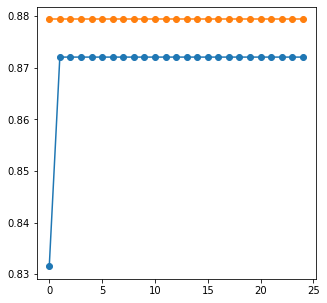

In [125]:
tac = [t.item() for t in train_accs]
vac = [v.item() for v in val_accs]

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(list(range(25)), tac, 'o-')
ax.plot(list(range(25)), vac, 'o-')

In [128]:
import pickle

with open('./tac.pkl', 'wb') as handle:
    pickle.dump(tac, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('./vac.pkl', 'wb') as handle:
    pickle.dump(vac, handle, protocol=pickle.HIGHEST_PROTOCOL)

## old

In [42]:
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainl_rgb, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

RuntimeError: Given groups=1, weight of size [4, 1, 4, 4], expected input[8, 3, 400, 400] to have 1 channels, but got 3 channels instead